In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import netCDF4 as nc
import datetime as dt
import cmocean
import string
import glob
import pickle
import matplotlib as mpl
from salishsea_tools import evaltools as et
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter
#from NorthNut import vvl_interp_T_to_V, vvl_interp_T_to_U;

%matplotlib inline

calculations have been moved to calcTranspsEstuarineExchange.py

In [2]:
SOGtmaskPath='../../save/SOGtmask.pkl'
(tmaskSOG,ig0,ig1,jg0,jg1)=pickle.load(open(SOGtmaskPath,'rb'))

In [3]:
tmaskSOG.shape,ig0

((1, 40, 898, 398), 110)

In [4]:
fformat0='%Y%m%d'
mod_start=dt.datetime(2015,1,1)
mod_end=dt.datetime(2015,12,31)
savepath='../../save/transpLines'+mod_start.strftime(fformat0)+'-'+mod_end.strftime(fformat0)+'.pkl'

In [5]:
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/rivers-climatology/bio/R201812_bioConst.nc') as fconst:
    dia=np.copy(fconst.variables['dia'])
    phy=np.copy(fconst.variables['phy'])
    mru=np.copy(fconst.variables['mes'])
    zoo=np.copy(fconst.variables['zoo'])
    don=np.copy(fconst.variables['don'])
    pon=np.copy(fconst.variables['pon'])
    bsi=np.copy(fconst.variables['bsi'])
    nh4=np.copy(fconst.variables['nh4'])
    silc=np.copy(fconst.variables['nh4'])# use this to define Fraser mask

In [6]:
np.shape(silc)

(1, 898, 398)

4.42713321781369


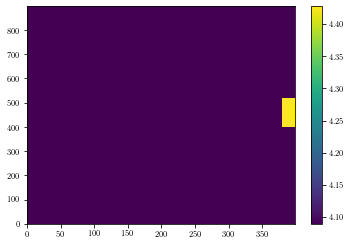

In [7]:
plt.pcolormesh(silc[0,:,:])
plt.colorbar()
print(np.max(silc))

In [8]:
tmaskFra=np.where(silc[0,:,:]==np.max(silc),1,0)

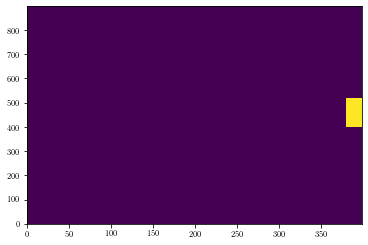

In [9]:
plt.pcolormesh(tmaskFra)

In [10]:
for el in (dia,phy,mru,zoo,don,pon,bsi,nh4):
    print(np.min(el),np.max(el))

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
4.09 4.42713321781369


In [11]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    A=fm.variables['e1t'][0,jg0:jg1,ig0:ig1]*fm.variables['e2t'][0,jg0:jg1,ig0:ig1]*fm.variables['tmask'][0,0,jg0:jg1,ig0:ig1]
SOGmask=tmaskSOG[0,0,jg0:jg1,ig0:ig1]
Framask=tmaskFra[jg0:jg1,ig0:ig1]
nh4=nh4[0,jg0:jg1,ig0:ig1]

In [12]:
## for HC201812 only need to consider nh4, silicate and no3

In [13]:
# calc daily river flux starting at 1am, with interpolation as in model
rau0 = 1026.0
t0=dt.datetime(2015,1,1)
te=dt.datetime(2018,1,1)
runlen=int((te-t0).total_seconds()/(24*3600))
fformatbio='/data/eolson/results/MEOPAR/NEMO-forcing-new/rivers-climatology/bio/R201809_2_bioClim_m%md%d.nc'
fformatFlow='/results/forcing/rivers/R201702DFraCElse_y%Ym%md%d.nc'
var=np.zeros((runlen*24,))
# SOG Rivers includes Fraser, but also save Fraser separately for reference
sumSilSOGRivers=np.copy(var) # silicate
sumSilFraser=np.copy(var)
sumNO3SOGRivers=np.copy(var)
sumNO3Fraser=np.copy(var)
sumNH4SOGRivers=np.copy(var)
sumNH4Fraser=np.copy(var)
times=list()
jj=-1
# NEMO performs interpolation between mid-day of neighboring days (assumes forcing data at noon)
fbiob=nc.Dataset((t0-dt.timedelta(days=1)).strftime(fformatbio))
fbion=nc.Dataset(t0.strftime(fformatbio))
fflb=nc.Dataset((t0-dt.timedelta(days=1)).strftime(fformatFlow))
ffln=nc.Dataset(t0.strftime(fformatFlow))
for idt0 in [t0+dt.timedelta(days=ii*1) for ii in range(0,runlen)]:
    fbioa=nc.Dataset((idt0+dt.timedelta(days=1)).strftime(fformatbio))
    ffla=nc.Dataset((idt0+dt.timedelta(days=1)).strftime(fformatFlow))
    flowb=fflb.variables['rorunoff'][0,jg0:jg1,ig0:ig1]
    flown=ffln.variables['rorunoff'][0,jg0:jg1,ig0:ig1]
    flowa=ffla.variables['rorunoff'][0,jg0:jg1,ig0:ig1]
    silb=fbiob.variables['sil'][0,jg0:jg1,ig0:ig1]
    siln=fbion.variables['sil'][0,jg0:jg1,ig0:ig1]
    sila=fbioa.variables['sil'][0,jg0:jg1,ig0:ig1]
    no3b=fbiob.variables['no3'][0,jg0:jg1,ig0:ig1]
    no3n=fbion.variables['no3'][0,jg0:jg1,ig0:ig1]
    no3a=fbioa.variables['no3'][0,jg0:jg1,ig0:ig1]
    for hh in range(0,24):
        jj=jj+1
        times.append(idt0+dt.timedelta(hours=hh))
        if hh<12:
            flow=.5*flowb+.5*flown+(flown-flowb)/24*hh
            sil=.5*silb+.5*siln+(siln-silb)/24*hh
            no3=.5*no3b+.5*no3n+(no3n-no3b)/24*hh
        else:
            flow=1.5*flown-0.5*flowa+(flowa-flown)/24*hh
            sil=1.5*siln-0.5*sila+(sila-siln)/24*hh
            no3=1.5*no3n-0.5*no3a+(no3a-no3n)/24*hh
        sumSilSOGRivers[jj]=np.sum(np.sum((1/rau0*3600*1e-3)*A*SOGmask*flow*sil,1),0) # hourly rates (mol/hr)
        # m3/kg * s/hr * mol/mmol * m2 * kg/m2/s *mmol/m3=
                # /hr * mol  = mol/hr
        sumSilFraser[jj]=np.sum(np.sum((1/rau0*3600*1e-3)*A*Framask*flow*sil,1),0) # hourly rates
        sumNO3SOGRivers[jj]=np.sum(np.sum((1/rau0*3600*1e-3)*A*SOGmask*flow*no3,1),0)
        sumNO3Fraser[jj]=np.sum(np.sum((1/rau0*3600*1e-3)*A*Framask*flow*no3,1),0)
        sumNH4SOGRivers[jj]=np.sum(np.sum((1/rau0*3600*1e-3)*A*SOGmask*flow*nh4,1),0)
        sumNH4Fraser[jj]=np.sum(np.sum((1/rau0*3600*1e-3)*A*Framask*flow*nh4,1),0)
    fbiob.close()
    fbiob=fbion
    fbion=fbioa
    fflb.close()
    fflb=ffln
    ffln=ffla
    print(idt0)
fbiob.close()
fbion.close()
fflb.close()
ffln.close()
times=np.array(times)

2015-01-01 00:00:00
2015-01-02 00:00:00
2015-01-03 00:00:00
2015-01-04 00:00:00
2015-01-05 00:00:00
2015-01-06 00:00:00
2015-01-07 00:00:00
2015-01-08 00:00:00
2015-01-09 00:00:00
2015-01-10 00:00:00
2015-01-11 00:00:00
2015-01-12 00:00:00
2015-01-13 00:00:00
2015-01-14 00:00:00
2015-01-15 00:00:00
2015-01-16 00:00:00
2015-01-17 00:00:00
2015-01-18 00:00:00
2015-01-19 00:00:00
2015-01-20 00:00:00
2015-01-21 00:00:00
2015-01-22 00:00:00
2015-01-23 00:00:00
2015-01-24 00:00:00
2015-01-25 00:00:00
2015-01-26 00:00:00
2015-01-27 00:00:00
2015-01-28 00:00:00
2015-01-29 00:00:00
2015-01-30 00:00:00
2015-01-31 00:00:00
2015-02-01 00:00:00
2015-02-02 00:00:00
2015-02-03 00:00:00
2015-02-04 00:00:00
2015-02-05 00:00:00
2015-02-06 00:00:00
2015-02-07 00:00:00
2015-02-08 00:00:00
2015-02-09 00:00:00
2015-02-10 00:00:00
2015-02-11 00:00:00
2015-02-12 00:00:00
2015-02-13 00:00:00
2015-02-14 00:00:00
2015-02-15 00:00:00
2015-02-16 00:00:00
2015-02-17 00:00:00
2015-02-18 00:00:00
2015-02-19 00:00:00


2016-02-15 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00
2016-02-20 00:00:00
2016-02-21 00:00:00
2016-02-22 00:00:00
2016-02-23 00:00:00
2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-27 00:00:00
2016-02-28 00:00:00
2016-02-29 00:00:00
2016-03-01 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-05 00:00:00
2016-03-06 00:00:00
2016-03-07 00:00:00
2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-12 00:00:00
2016-03-13 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00
2016-03-16 00:00:00
2016-03-17 00:00:00
2016-03-18 00:00:00
2016-03-19 00:00:00
2016-03-20 00:00:00
2016-03-21 00:00:00
2016-03-22 00:00:00
2016-03-23 00:00:00
2016-03-24 00:00:00
2016-03-25 00:00:00
2016-03-26 00:00:00
2016-03-27 00:00:00
2016-03-28 00:00:00
2016-03-29 00:00:00
2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-02 00:00:00
2016-04-03 00:00:00
2016-04-04 00:00:00


2017-03-31 00:00:00
2017-04-01 00:00:00
2017-04-02 00:00:00
2017-04-03 00:00:00
2017-04-04 00:00:00
2017-04-05 00:00:00
2017-04-06 00:00:00
2017-04-07 00:00:00
2017-04-08 00:00:00
2017-04-09 00:00:00
2017-04-10 00:00:00
2017-04-11 00:00:00
2017-04-12 00:00:00
2017-04-13 00:00:00
2017-04-14 00:00:00
2017-04-15 00:00:00
2017-04-16 00:00:00
2017-04-17 00:00:00
2017-04-18 00:00:00
2017-04-19 00:00:00
2017-04-20 00:00:00
2017-04-21 00:00:00
2017-04-22 00:00:00
2017-04-23 00:00:00
2017-04-24 00:00:00
2017-04-25 00:00:00
2017-04-26 00:00:00
2017-04-27 00:00:00
2017-04-28 00:00:00
2017-04-29 00:00:00
2017-04-30 00:00:00
2017-05-01 00:00:00
2017-05-02 00:00:00
2017-05-03 00:00:00
2017-05-04 00:00:00
2017-05-05 00:00:00
2017-05-06 00:00:00
2017-05-07 00:00:00
2017-05-08 00:00:00
2017-05-09 00:00:00
2017-05-10 00:00:00
2017-05-11 00:00:00
2017-05-12 00:00:00
2017-05-13 00:00:00
2017-05-14 00:00:00
2017-05-15 00:00:00
2017-05-16 00:00:00
2017-05-17 00:00:00
2017-05-18 00:00:00
2017-05-19 00:00:00


In [14]:
fformat0='%Y%m%d'
rivFluxPath='../../save/rivFluxesHrly'+t0.strftime(fformat0)+'-'+te.strftime(fformat0)+'.pkl'

pickle.dump((times,sumSilSOGRivers,sumSilFraser,sumNO3SOGRivers,sumNO3Fraser,sumNH4SOGRivers,sumNH4Fraser),
            open(rivFluxPath,'wb'))

In [3]:
test=nc.Dataset('/results/forcing/rivers/R201702DFraCElse_y2015m01d01.nc')

In [4]:
test

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Real Fraser Values, Daily Climatology for Other Rivers
    dimensions(sizes): x(398), y(898), time_counter(1)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 time_counter(time_counter), float32 rorunoff(time_counter,y,x)
    groups: 

In [5]:
test.variables['rorunoff']

<class 'netCDF4._netCDF4.Variable'>
float32 rorunoff(time_counter, y, x)
    _Fillvalue: 0.0
    _missing_value: 0.0
    _units: kg m-2 s-1
unlimited dimensions: time_counter
current shape = (1, 898, 398)
filling on, default _FillValue of 9.969209968386869e+36 used

In [6]:
test.close()